## Analyzing the extracted tweets
Mesaye Bahiru, Brock Beckley, Danyal Hamid, Mohamad Khalili, Mehdi Yachfine.

The scraper has been run before this notebook and the obtained .csv file is tweets_btc.csv. 

In [ ]:
#pip install pyspark
!pip install keras

In [ ]:
import pandas as pd 
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
!pip install ekphrasis
!pip install tweet-preprocessor
import preprocessor as p
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Step 1: Pre-Processing the tweets

In this step, we have to transform the tweets into "normal" language. Emojis, mentions and hashtags are removed. Once we have the "normal" language, we can perform the normal steps of text pre-processing, such as lowercasing, removal of punctuation, removal of stopwords and tokenization

In [ ]:
tweets = pd.read_csv('tweets_btc.csv')
tweets = tweets.drop([tweets.columns[0]],axis=1)

#Transforming a tweet into normal text: removing hashtags, mentions:
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    return text

tweets['Normal_Text'] = tweets.apply(preprocess_tweet, axis = 1)

#Removing stopwords
stop = stopwords.words('english')
tweets['Clean_Tweet'] = tweets['Normal_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Lowercasing the tweets:
for i in range(len(tweets)):
    tweets['Clean_Tweet'][i] = tweets['Clean_Tweet'][i].lower()
    
#Removing punctuation:
import string
def remove_punct(txt):
    text_nopunct= "".join([char for char in txt if char not in string.punctuation])
    return text_nopunct
tweets['Finished_Tweet']= tweets['Clean_Tweet'].apply(lambda x: remove_punct(x))

#Tokenizing into words:
    
tweets['tokenized_tweet'] = 0
for i in range(len(tweets)):
    tweets['tokenized_tweet'][i] = word_tokenize(tweets['Finished_Tweet'][i])

tweets.head()

,id,created_at,text,Normal_Text,Clean_Tweet,Finished_Tweet,tokenized_tweet
0,1492483100756307970,2022-02-12 13:00:00+00:00,RT @AirdropDet: 🔍New #Airdrop: payMe Trivia Qu...,: New : payMe Trivia QuizReward: Up to K payME...,: new : payme trivia quizreward: up k payme (~...,new payme trivia quizreward up k payme 35 m...,"[new, payme, trivia, quizreward, up, k, payme,..."
1,1492483099930013698,2022-02-12 13:00:00+00:00,RT @deficonnect: Next on the list....🚀\n\nDEFI...,: Next on the list....DEFIPAY..,: next list....defipay..,next listdefipay,"[next, listdefipay]"
2,1492483099527110658,2022-02-12 13:00:00+00:00,RT @CihanYedek: BobNftDesign NFT Giveaway\nHon...,: BobNftDesign NFT GiveawayHonouring Bob Marle...,: bobnftdesign nft giveawayhonouring bob marle...,bobnftdesign nft giveawayhonouring bob marley...,"[bobnftdesign, nft, giveawayhonouring, bob, ma..."
3,1492483099485085699,2022-02-12 13:00:00+00:00,RT @AirdropStario: 💧 NFTOCEAN Airdrop 💧\n\n🏆 T...,: NFTOCEAN Airdrop Task: NO Referral: NO Airdr...,: nftocean airdrop task: no referral: no airdr...,nftocean airdrop task no referral no airdrop ...,"[nftocean, airdrop, task, no, referral, no, ai..."
4,1492483098717884416,2022-02-12 13:00:00+00:00,RT @cmttat: wen btc 100k ? :(,: wen btc k ?,: wen btc k ?,wen btc k,"[wen, btc, k]"


## Step 2: VADER Sentiment Analysis

Now that the tweets are cleaned and fully pre-processed, we can proceed with the VADER sentiment analysis, which will calculate a negative, neutral and positive polarity score for each tweet, as well as a compound polarity score. The compound polarity scores have been average for each hour, that way, we have an average hourly sentiment linked with an hourly price for bitcoin.

In [ ]:
# VADER SENTIMENT ANALYSIS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Iterate through the headlines and get the polarity scores using vader
scores = tweets['Finished_Tweet'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
tweets = tweets.join(scores_df, rsuffix='_right')


#selecting the data we will need
df = tweets[['created_at', 'compound']]
df.created_at = pd.to_datetime(df['created_at'])

#Getting the day and hour to get the mean sentiment score per hour
def get_hour(date):
    return date.hour
def get_day(date):
    return date.day

df['hour'] = df.created_at.apply(get_hour)
df['day'] = df.created_at.apply(get_day)

#Getting the mean sentiment score per hour
df2 = df.groupby(['day','hour']).mean().reset_index()
df2.head()

,day,hour,compound
0,5,20,0.300386
1,5,21,0.178428
2,5,22,0.171779
3,5,23,0.223601
4,6,0,0.177892


## Step 3: Preparing the dataset for sentiment-based price prediction using LSTM.

In this section, we are preparing the dataset in order to predict the price of bitcoin solely based on the average hourly compound sentiments.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
price = pd.read_csv('bitcoin_price.csv')

price = price.drop(price.index[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]])
price = price.reset_index(drop = True)

df2 = df2.drop(df2.index[[154,155,156,157,158,159,160,161]])
df2 = df2.reset_index(drop = True)

Dataframe_Final = pd.DataFrame(columns = ['Sentiment','Price'])


Dataframe_Final['Sentiment'] = df2['compound']
Dataframe_Final['Price'] = price['Close']

Dataframe_Final = Dataframe_Final[['Price','Sentiment']]

n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(Dataframe_Final.values)

reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()


,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
3,0.079152,0.607599,0.096644,0.226274,0.076380,0.205486,0.038998
4,0.096644,0.226274,0.076380,0.205486,0.038998,0.367518,0.057684
5,0.076380,0.205486,0.038998,0.367518,0.057684,0.224599,0.082914
6,0.038998,0.367518,0.057684,0.224599,0.082914,0.456722,0.054584
7,0.057684,0.224599,0.082914,0.456722,0.054584,0.522070,0.049939


In [ ]:
#Installing the required packages for LSTM:

#!pip install pyspark
import tensorflow
import keras
import pyspark as spark
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
values = reframed.values
n_train_hours = 110
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(110, 3, 1) (110,) (41, 3, 1) (41,)


## Step 4: Training the Neural Network

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/30
28/28 - 4s - loss: 0.4395 - val_loss: 0.4197 - 4s/epoch - 127ms/step
Epoch 2/30
28/28 - 0s - loss: 0.3607 - val_loss: 0.3348 - 133ms/epoch - 5ms/step
Epoch 3/30
28/28 - 0s - loss: 0.3137 - val_loss: 0.2639 - 143ms/epoch - 5ms/step
Epoch 4/30
28/28 - 0s - loss: 0.2696 - val_loss: 0.1966 - 117ms/epoch - 4ms/step
Epoch 5/30
28/28 - 0s - loss: 0.2244 - val_loss: 0.1452 - 116ms/epoch - 4ms/step
Epoch 6/30
28/28 - 0s - loss: 0.1859 - val_loss: 0.1163 - 130ms/epoch - 5ms/step
Epoch 7/30
28/28 - 0s - loss: 0.1640 - val_loss: 0.1076 - 121ms/epoch - 4ms/step
Epoch 8/30
28/28 - 0s - loss: 0.1527 - val_loss: 0.1230 - 140ms/epoch - 5ms/step
Epoch 9/30
28/28 - 0s - loss: 0.1497 - val_loss: 0.1356 - 129ms/epoch - 5ms/step
Epoch 10/30
28/28 - 0s - loss: 0.1491 - val_loss: 0.1372 - 114ms/epoch - 4ms/step
Epoch 11/30
28/28 - 0s - loss: 0.1474 - val_loss: 0.1340 - 123ms/epoch - 4ms/step
Epoch 12/30
28/28 - 0s - loss: 0.1444 - val_loss: 0.1327 - 123ms/epoch - 4ms/step
Epoch 13/30
28/28 - 0s - l

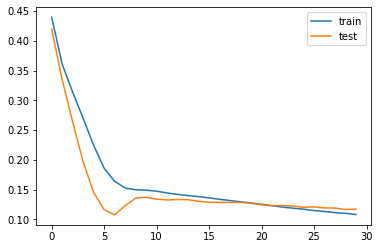

In [ ]:
#Plotting the loss functions:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 5: Predicting the price for the next 40 minutes based on the sentiments of the previous 110 minutes:

In [ ]:
import numpy as np
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 571.941


Plotting the prediction:

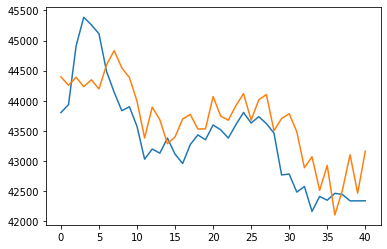

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

## Step 6: Creating a word cloud

On Twitter, when people talk about blockchain and cryptocurrencies, they talk about a lot more than just Bitcoin. Generating a word cloud allows us to see what topics are the most recurring ones around Bitcoin. 

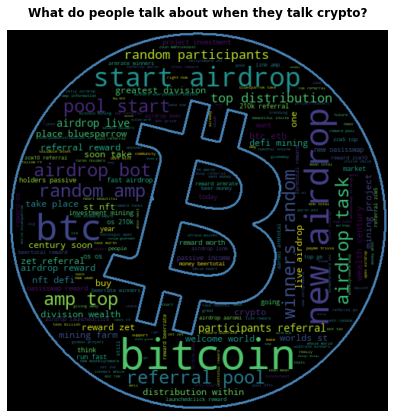

In [ ]:
#Word Cloud

import numpy as np
from wordcloud import WordCloud
from PIL import Image # for world cloud image
review = [' '.join(words) for words in tweets["tokenized_tweet"]]

long_string = ','.join(list(review))

# Import image
#btcmask = np.array(Image.open("C:/Users/Brock/Desktop/640px-BTC_Logosvg.png"))
btcmask = np.array(Image.open('bitcoin.png'))

# Create a WordCloud object

#Add image related to BTC
#wordcloud = WordCloud(background_color="white", mask=btcmask, max_words=100, contour_width=3, contour_color='steelblue')

wordcloud = WordCloud(background_color="black", mask = btcmask, max_words=200, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("What do people talk about when they talk crypto?", pad = 14, weight = 'bold')

plt.show()


## Step 7: MDS Plot & Lift values

The cryptocurrency market being highly volatile, other cryptocurrencies and some high-profile individuals can have an impact on the price of Bitcoin. By calculating lift values of cryptocurrencies, we can quantitatively observe which cryptocurrencies are the most associated together, and which individuals are associated with which cryptocurrencies.

The top 10 names by frequency are: 
          name  frequency
94      Macys       8883
11    Bitcoin       7908
93       Visa       2317
7    Ethereum       2196
35    Siacoin        878
45  300 Token        358
38     Tether        313
42         0x        298
6    Dogecoin        235
46    42-coin        223


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:518: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  "The MDS API has changed. ``fit`` now constructs an"


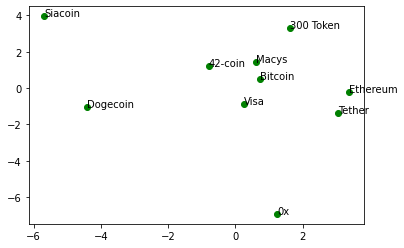

In [ ]:
#Lift values and MDS plot with other cryptos:

#IMPORTING THE PACKAGES ---------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import preprocessor as p
import warnings
import re 
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


# NLP packages
import nltk
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go

#READING THE FILE AND NAMING THE COLUMNS ----------------------------------
df = pd.read_csv('tweets_btc.csv')

invest_df = pd.read_csv('investment.csv', header=None)
invest_df.columns = ['name', 'symbol']

#FINDING AND REPLACING MODELS BY THE BRANDS -------------------------------
for i in range(len(df)):
#    print(i)
    for j in range(len(invest_df)):
        name = invest_df.name[j]
        symbol = invest_df.symbol[j]
        
        if symbol in df.text[i]:
            df.text[i] = df.text[i].replace(symbol,name)
            #print(symbol, name)


#DATA PRE-PROCESSING -------------------------------------------------------
#Transforming a tweet into normal text: removing hashtags, mentions:
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    return text

df['Normal_Text'] = df.apply(preprocess_tweet, axis = 1)


# remove punctuation
import string
string.punctuation


def remove_punct(txt):
    text_nopunct= "".join([char for char in txt if char not in string.punctuation])
    return text_nopunct
df["clean_text"]= df["Normal_Text"].apply(lambda x: remove_punct(x))

df.head()

#Lowercasing the tweets:
for i in range(len(df)):
    df['clean_text'][i] = df['clean_text'][i].lower()
    
    
#word tokenization    

def tokenize(txt2):
    tokens= re.split('\W+',txt2)
    return tokens  
df["tokenized_tweet"]= df["clean_text"].apply(lambda x: tokenize(x))

df.head()

#Removing stopwords


from nltk.corpus import stopwords

stopwords= nltk.corpus.stopwords.words("english")
stopwords[0:10]
def remove_stopwords(txt3):
    post_nostop= [word for word in txt3 if word not in stopwords]
    return post_nostop

df["Clean_Tweet"]= df["tokenized_tweet"].apply(lambda x: remove_stopwords(x))

# Stemmer
ps= nltk.PorterStemmer()

def stemm_tokens(post_stem):
    stem_list= [ps.stem(word) for word in post_stem]
    return stem_list

df["post_stemmed"]= df["Clean_Tweet"].apply(lambda x: stemm_tokens(x))


df.shape
## bring all the text

def converge(txt2):
    tokens= ' '.join(txt2)
    return tokens
df["ready_tweet"]= df["post_stemmed"].apply(lambda x: converge(x))



#IDENTIFYING THE TOP 10 Names BY FREQUENCY -------------------------------


name_df = pd.DataFrame(invest_df.name.unique(), columns = ['name'])

name_df['frequency'] = 0
N = len(df)
for i in range(len(df)):
#    print(i)
    for j in range(len(name_df)):
        if(name_df.name[j] in df.text[i]):
            name_df.frequency[j] += 1

#Getting rid of the rows with frequency = 0
name_df = name_df.drop(name_df[name_df.frequency == 0].index)


# Top 10 by frequency
top_10 = name_df.nlargest(10, 'frequency')
print('The top 10 names by frequency are: \n',top_10)


# CALCULATING THE LIFT VALUES -----------------------------------------------
top_10 = top_10.reset_index()
top_10 = top_10.drop(columns = 'index')

N = len(df) #total number of posts
n_name = len(top_10) #total number of names detected in the posts

#Defining the lift matrix and the co-frequencies matrix #(A,B)
lift_matrix = np.zeros((n_name,n_name))
co_freq_matrix = np.zeros((n_name,n_name))

#Get the number of occurence of two name simultaneously
for k in range(N):
#    print(k)
    for i in range(n_name):
        for j in range(n_name):  
            #if brand i  and brand j in the same post, frequency += 1 
            if(i != j and (top_10.name[i] in df.text[k]) and (top_10.name[j] in df.text[k] )):
                co_freq_matrix[i,j] += 1
            
#Filling the lift matrix with 1/lift
for i in range(n_name):
    for j in range(n_name):
        if(i != j):
            lift_matrix[i,j] = (N*co_freq_matrix[i,j])/( top_10.frequency[i] * top_10.frequency[j] ) #was brand_df, replaced with top_10

#Keeping only the upper triangle of the matrix as the lift is symetric

lift_matrix_upper = np.triu(lift_matrix,0)

lift_table = pd.DataFrame(lift_matrix_upper, columns=top_10.name, index=top_10.name)


# PLOTTING THE MDS PLOT ----------------------------------------------------
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(lift_matrix)
X_transformed.shape

#Converting to dataframe
X_transformed = pd.DataFrame(X_transformed, columns=['first', 'second'])
#Adding the brands to display them on the graph
X_transformed['name'] = top_10.name

#X_transformed.plot(kind='scatter', x='first', y='second')

#Graph
fig, ax = plt.subplots()
ax.scatter(x=X_transformed['first'],y=X_transformed['second'],c='green')

# annotate points in axis
for idx, row in X_transformed.iterrows():
    ax.annotate(row['name'], (row['first'], row['second']) )
# force matplotlib to draw the graph
plt.show()

In [ ]:
lift_table

name,Macys,Bitcoin,Visa,Ethereum,Siacoin,300 Token,Tether,0x,Dogecoin,42-coin
name,,,,,,,,,,
Macys,0.0,1.023452,1.346143,1.044982,1.468107,1.059881,1.009250,1.437771,1.066118,1.001369
Bitcoin,0.0,0.000000,1.211978,1.475633,1.398263,0.227858,1.068529,1.320772,1.579394,1.463194
Visa,0.0,0.000000,0.000000,1.369238,2.568491,0.155537,1.245292,1.751752,1.658623,1.310907
Ethereum,0.0,0.000000,0.000000,0.000000,2.124518,0.348728,0.891580,2.094710,4.437534,0.987956
Siacoin,0.0,0.000000,0.000000,0.000000,0.000000,0.102614,2.640750,8.382657,1.328740,1.070773
300 Token,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.431765,0.604664,0.383383,0.404013
Tether,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.074790,4.385018,2.079442
0x,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.224018,1.941433
Dogecoin,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.923213


100
             name  frequency
49       @evankuo          0
68  @VinnyLingham          0
66     @arrington          0
65    @NickSzabo4          0
64    @apompliano          0
..            ...        ...
21         @tyler         17
7           @jack         27
72       @danheld         28
0     @cz_binance        105
99      @elonmusk        147

[98 rows x 2 columns]


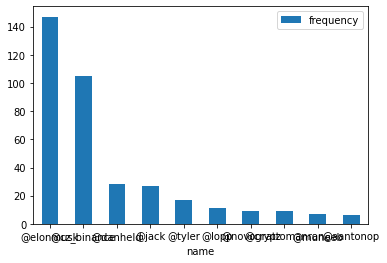

In [ ]:
#Lift values with people:

ppl = pd.read_csv('ppl4.csv')
unique_people = pd.DataFrame(ppl['name'].unique(), columns = ['name'])
unique_people['frequency'] = 0

unique_people.head()

print(len(unique_people))

#Counting the word occurrences
for i in range(len(df)):
#    print(i)
    for j in range(len(unique_people)):
            if(unique_people.name[j] in df.text[i]):
                unique_people.frequency[j] += 1

unique_people = unique_people[unique_people.name != '@']
unique_people = unique_people[unique_people.name != 'der']
print(unique_people.sort_values(by=['frequency']))


#Obtaining and plotting the top 10
top5_people = unique_people.nlargest(10, 'frequency')

top5_people = top5_people.set_index('name')

ax = top5_people.plot.bar(rot=0)


# CALCULATING THE LIFT VALUES -----------------------------------------------
top_10 = top_10.reset_index()
top_10 = top_10.drop(columns = 'index')

N = len(df) #total number of posts
n_name = len(top_10) #total number of names detected in the posts

#Defining the lift matrix and the co-frequencies matrix #(A,B)
lift_matrix1 = np.zeros((n_name,len(top5_people)))
co_freq_matrix1 = np.zeros((n_name,len(top5_people)))

#Get the number of occurence of two name simultaneously
for k in range(N):
#    print(k)
    for i in range(n_name):
        for j in range(len(top5_people)):  
            #if brand i  and brand j in the same post, frequency += 1 
            if((top_10.name[i] in df.text[k]) and (top5_people.index[j] in df.text[k] )):
                co_freq_matrix1[i,j] += 1
            
#Filling the lift matrix with 1/lift
for i in range(n_name):
    for j in range(len(top5_people)):
        lift_matrix1[i,j] = (N*co_freq_matrix1[i,j])/( top_10.frequency[i] * top5_people.frequency[j] ) #was brand_df, replaced with top_10

lift_table1 = pd.DataFrame(lift_matrix1, columns=top_10.name, index=top5_people.index)

In [ ]:
lift_table1

name,Macys,Bitcoin,Visa,Ethereum,Siacoin,300 Token,Tether,0x,Dogecoin,42-coin
name,,,,,,,,,,
@elonmusk,1.222677,1.020133,0.259356,1.008606,0.213587,0.165045,1.008606,0.806885,0.778067,0.302582
@cz_binance,1.456662,1.165330,1.966494,1.737205,1.199604,0.556180,1.132960,1.132960,1.456662,1.699439
@danheld,1.231072,1.723501,0.000000,1.288943,0.000000,0.000000,2.320098,3.866830,1.988655,0.000000
@jack,1.698568,1.188997,0.000000,0.815979,1.295966,0.000000,4.079893,0.000000,1.049115,1.223968
@tyler,2.374080,5.073034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
@lopp,0.306445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
@novogratz,0.701006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
@cryptomanran,2.208875,9.277277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
@muneeb,2.334202,1.307153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.437589


In [ ]:
top5_people

,frequency
name,
@elonmusk,147
@cz_binance,105
@danheld,28
@jack,27
@tyler,17
@lopp,11
@novogratz,9
@cryptomanran,9
@muneeb,7
